# Blasius/Falkner-Skan equation
Solved using a simple shooting/bisection method and Runge-Kutta RK4 integration.

Adapted 2021-2024 by Philipp Schlatter

 Binder: https://mybinder.org/v2/gh/pschlatt1/notebooks/main?filepath=fs.ipynb
 
 Colab: https://colab.research.google.com/github/pschlatt1/notebooks/blob/main/fs.ipynb

Preliminaries: To run on Google CoLab use either %matplotlib inline or !pip install ipympl; from google.colab import output; output.enable_custom_widget_manager(); %matplotlib widget

In [20]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  # for Google Colab and interative figures
  !pip install -q ipympl
  from google.colab import output
  output.enable_custom_widget_manager()

In [21]:
# if you want LaTeX fonts on Google CoLab use this plus set usetex:True
#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

In [22]:
%matplotlib notebook
#%matplotlib widget
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'legend.loc':'best',
          'figure.figsize': (8,5),
          'lines.markerfacecolor':'none',
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize':12,
          'ytick.labelsize':12,
          'grid.alpha':0.6,
          'text.usetex':False}
pylab.rcParams.update(params)

The equation to solve is
$$f'''+\frac{1}{2} f f'' + \frac{\beta_H }{2}(1-f' ^2) = 0 \ ,$$
subject to boundary conditions
$$f(0)=0, f'(0)=0, f'(\infty) = 1 \ .$$

The Hartree parameter $\beta_H$ is related to the acceleration of the velocity as $\beta_H=2m/(m+1)$. Positive $\beta_H$ lead to accelerating boundary layers (favourable pressure gradient, FPG), whereas negative $\beta_H$ are associated with adverse pressure gradient (APG). Separation would occur at $m=-0.090428$.

We thus define first our equation in vector form:

In [23]:
def ff(u):
    f0 =   u[1]
    f1 =   u[2] 
    f2 = - 0.5*u[0] * u[2]  - betaH/2*(1-u[1]**2)
    return np.array([f0,f1,f2])

and then the Runge-Kutta ODE integrator RK4, using the (unknown) initial value $a$ for $f''(0)$

In [24]:
def RK4(a,h,L):
    imax = int(L/h)
    X = np.arange(imax+1)*h
    U = np.zeros((imax+1,3)); U[0,:] = [0,0,a]
    for i in range(imax):  
        K1 = ff(U[i,:]       )
        K2 = ff(U[i,:]+K1*h/2)
        K3 = ff(U[i,:]+K2*h/2)
        K4 = ff(U[i,:]+K3*h  )
        U[i+1,:] = U[i,:] + h*(K1+2*K2+2*K3+K4)/6     
    return X,U

The shooting function returns the value $1-f'(\infty)$ (approximated as $1-f'(L)$):

In [25]:
def shoot(a,h,L):
    X,U = RK4(a,h,L)
    return (1.0-U[-1,1])

The function blasius is performing a bisection method, in an effort to bring the error of $f'(L)=1$ below the specified tolerance.  Note that the initial values for the bisection may need to be tweaked a bit.

In [26]:
def blasius(h,L,tol,nmax):
    if (betaH>0):
        a = 2*m+0.1; fa = shoot(a,h,L)
    else:
        a = 0.0; fa = shoot(a,h,L)
    b = 1.0; fb = shoot(b,h,L)
    if (fa*fb > 0 or np.isnan(fa*fb)):
        print(" f(a=%14.7f) = %14.7f" %(a,fa))
        print(" f(b=%14.7f) = %14.7f" %(b,fb))
        raise RuntimeError('Bad initial interval.') 
    n = 0; delta = (b-a)/2
    while (abs(delta) >= tol and n <= nmax):
        delta = (b-a)/2; n = n + 1;
        x = a + delta; fx = shoot(x,h,L)
        print(" x = %14.7e (Estimated error %14.7e at iteration %d)" % (x,abs(delta),n))
        if (fx*fa > 0):
            a = x;  fa = fx
        else:
            b = x;  fb = fx
        if (n > nmax):
            raise RuntimeError('Too many iterations.') 
    return x

Finally, the main script calls the blasius function and computes the solution in $\eta$ and $f$

In [27]:
# parameters
nmax = 100
h   = 0.01
L   = 30
tol = 1e-8
m=-0.090428  # minimum possible value
m=0.2  # favourable pressure gradient (FPG)
m=-0.09  # adverse pressure gradient (APG)
#m=0  # zero pressure gradient (ZPG)

# Compute the Hartree-beta
betaH=2*m/(m+1)
print(" m=%14.7e  beta_H = %14.7e  wedge angle (degrees): %14.7e" % (m,betaH,betaH*180))

 m=-9.0000000e-02  beta_H = -1.9780220e-01  wedge angle (degrees): -3.5604396e+01


In [28]:
# compute the value of f''(0)
a = blasius(h,L,tol,nmax)
# recompute the Blasius solution with the optimised value for f''(0)
eta,f = RK4(a,h,L)

print("Final value for f''(0) = %14.10f" % f[0,2])

 x =  5.0000000e-01 (Estimated error  5.0000000e-01 at iteration 1)
 x =  2.5000000e-01 (Estimated error  2.5000000e-01 at iteration 2)
 x =  1.2500000e-01 (Estimated error  1.2500000e-01 at iteration 3)
 x =  6.2500000e-02 (Estimated error  6.2500000e-02 at iteration 4)
 x =  3.1250000e-02 (Estimated error  3.1250000e-02 at iteration 5)
 x =  1.5625000e-02 (Estimated error  1.5625000e-02 at iteration 6)
 x =  2.3437500e-02 (Estimated error  7.8125000e-03 at iteration 7)
 x =  1.9531250e-02 (Estimated error  3.9062500e-03 at iteration 8)
 x =  2.1484375e-02 (Estimated error  1.9531250e-03 at iteration 9)
 x =  2.0507812e-02 (Estimated error  9.7656250e-04 at iteration 10)
 x =  2.0019531e-02 (Estimated error  4.8828125e-04 at iteration 11)
 x =  1.9775391e-02 (Estimated error  2.4414062e-04 at iteration 12)
 x =  1.9897461e-02 (Estimated error  1.2207031e-04 at iteration 13)
 x =  1.9836426e-02 (Estimated error  6.1035156e-05 at iteration 14)
 x =  1.9805908e-02 (Estimated error  3.051

Finally, let us plot the results for the similarity function

<IPython.core.display.Javascript object>


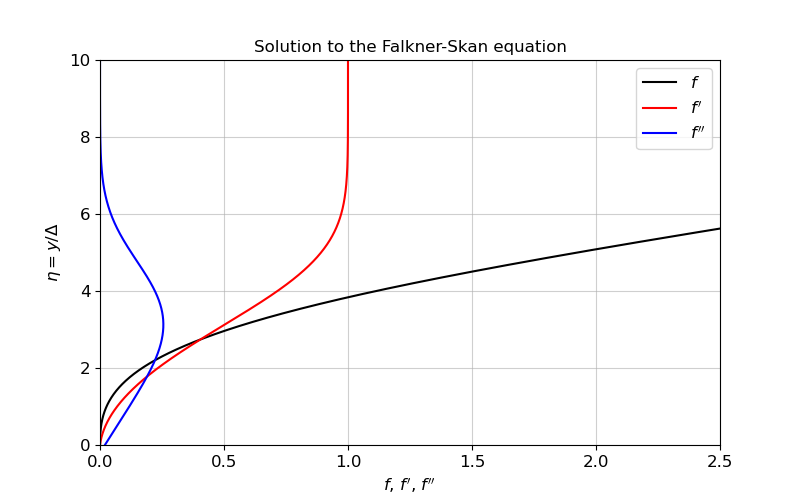

In [29]:
fig=plt.figure()
fig.canvas.header_visible = False
plt.title('Solution to the Falkner-Skan equation')
plt.plot(f[:,0],eta,'-k',label="$f$")
plt.plot(f[:,1],eta,'-r',label="$f'$")
plt.plot(f[:,2],eta,'-b',label="$f''$")
plt.xlim([0, 2.5])
plt.ylim([0,10])
plt.grid()
plt.xlabel(r"$f$, $f'$, $f''$")
plt.ylabel(r'$\eta=y/\Delta$')
plt.legend(loc='best')
plt.show()

Let us now compute some integral quantities: (Blasius length scale $\Delta$, boundary-layer thickness $\delta_{99}$, displacement thickness $\delta^*$, momentum-loss thickness $\theta$, shape factor $H_{12}$)

In [30]:
d99 = np.interp(0.99,f[:,1],eta)
d1 = eta[-1]-f[-1,0]
d2 = np.trapz(f[:,1]*(1-f[:,1]),eta)  # note the difference to Blasius!
H12 = d1/d2
print('d99   / Delta = %14.10g' % d99)
print('dstar / Delta = %14.10g' % d1)
print('theta / Delta = %14.10g' % d2)
print('H12           = %14.10g' % H12)
print('dstar/d99     = %14.10g' % float(d1/d99))
print('theta/d99     = %14.10g' % float(d2/d99))

d99   / Delta =    6.585933028
dstar / Delta =    3.151071054
theta / Delta =   0.8262982748
H12           =    3.813478922
dstar/d99     =   0.4784547673
theta/d99     =   0.1254641174


The thickness scale $$\Delta = \sqrt{\frac{1}{m+1}\frac{\nu x}{U_e}}  $$ is used for non-dimensionalisation of length, and $U_e=K x^m$ for velocity. Thus, the local skin-friction coefficient $$c_f = \frac{\tau_w}{\frac12 \rho U_e^2}= \frac{2f''(0)}{\sqrt{Re_x}}\sqrt{(m+1)} $$ is computed using the wall-shear stress $$\tau_w = \mu \frac{\mathrm \partial u}{\partial y}|_{y=0} =\mu \frac{U_e f''(0)}{\Delta} =\frac{\rho U_e^2}{\sqrt{Re_x}}f''(0) \sqrt{m+1}\ .$$

In [31]:
print("cf*sqrt(Rex) = %14.10g" % float(2*f[0,2]*np.sqrt(m+1)))

cf*sqrt(Rex) =  0.03774358242


The von Kármán integral equation states
$$\frac{\tau_w}{\rho} = c_f \cdot \frac12U_e^2 = U_e \frac{\mathrm d U_e}{\mathrm d x} (\delta^* + 2\theta) + U_e^2 \frac{\mathrm d \theta}{\mathrm d x} \ ,$$
which can be used to verify the above relation for $\tau_w$:
$$\tau_w = \frac{\rho U_e^2}{\sqrt{Re_x}} \sqrt{\frac{1}{m+1}}\left( m \frac{\delta^*}{\Delta} + \frac{\theta}{\Delta} \frac{1+3m}{2}\right)$$
and for $c_f$:
$$c_f = \frac{\tau_w}{\frac12 \rho U_e^2} = \frac{2}{\sqrt{Re_x}} \sqrt{\frac{1}{m+1}}\left( m \frac{\delta^*}{\Delta} + \frac{\theta}{\Delta} \frac{1+3m}{2}\right)$$

In [32]:
print("cf*sqrt(Rex) = %14.10g" % float(2*np.sqrt(1/(m+1))*(m*d1+d2*(1+3*m)/2)))

cf*sqrt(Rex) =  0.03774344401


These integral quantities can also be obtained by integration using the trapezoidal rule:

$$\delta^* = \int_0^\infty (1-u/u_\infty) \mathrm dy = \Delta \int_0^\infty (1-f') \mathrm d\eta$$

$$\theta = \int_0^\infty (u/u_\infty)(1-u/u_\infty) \mathrm dy = \Delta \int_0^\infty f'(1-f') \mathrm d\eta$$

In [33]:
np.trapz(1-f[:,1],eta)             # displacement thickness

3.1510712191913375

In [34]:
np.trapz(f[:,1]*(1-f[:,1]),eta)    # momentum thickness

0.8262982748100629